In [2]:
# ! pip install xclim 

In [3]:
%matplotlib inline 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os 
import gcsfs 
from matplotlib import cm
import warnings 

import seaborn as sbn
import yaml

import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
def read_gcs_zarr(zarr_url, token='/opt/gcsfuse_tokens/impactlab-data.json', check=False):
    """
    takes in a GCSFS zarr url, bucket token, and returns a dataset 
    Note that you will need to have the proper bucket authentication. 
    """
    fs = gcsfs.GCSFileSystem(token=token)
    
    store_path = fs.get_mapper(zarr_url, check=check)
    ds = xr.open_zarr(store_path)
    
    return ds 

def get_filepath(varname, model, stage, scen): 
    filepath = all_paths[model + '-' + varname][scen][stage]
    return filepath 

def load_zarr(filepath):
    ds = read_gcs_zarr(filepath)
    return ds 

with open('/home/jovyan/downscaling/downscale/notebooks/downscaling_pipeline/post_processing_and_delivery/data_paths.yaml', 'r') as f:
    all_paths = yaml.safe_load(f)

In [5]:
plot_dir = '/gcs/impactlab-data/climate/downscaling/paper/'

In [6]:
ref_coarse = read_gcs_zarr('gs://scratch-170cd6ec/8420f145-709a-4e6b-b3d3-c1a8bc8351e9/fig2-downscale-p455l-3388784717/rechunked.zarr')

ref_fine = read_gcs_zarr('gs://scratch-170cd6ec/8420f145-709a-4e6b-b3d3-c1a8bc8351e9/fig2-downscale-p455l-1338346969/rechunked.zarr')

qplad_model = read_gcs_zarr('gs://scratch-170cd6ec/8420f145-709a-4e6b-b3d3-c1a8bc8351e9/fig2-downscale-p455l-4180485512/qplad-model.zarr')

sim = read_gcs_zarr('gs://scratch-170cd6ec/8420f145-709a-4e6b-b3d3-c1a8bc8351e9/fig2-downscale-p455l-2148621694/regridded.zarr')

sim_coarse = read_gcs_zarr('gs://biascorrected-492e989a/stage/ScenarioMIP/MOHC/HadGEM3-GC31-LL/ssp245/r1i1p1f3/day/tasmax/gn/v20220217010508.zarr')

downscaled = load_zarr(get_filepath('tasmax', 'HadGEM3-GC31-LL', 'downscaled_delivered', 'ssp245'))

### extract all of the adjustment factors for Miami for all days of year/quantiles ### 

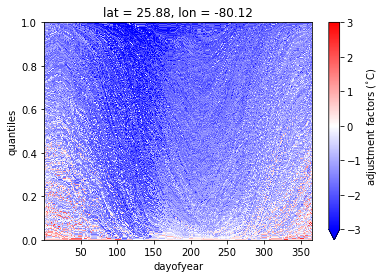

In [9]:

qplad_model.sel(lat=lat, lon=lon, method="nearest")['af'].plot(y='quantiles', vmin=-3, vmax=3, cmap='bwr', 
                                                              cbar_kwargs={'label': 'adjustment factors ($^{\circ}$C)'})

make cdfs of June 15th for the reference data (all month June) 

In [8]:
# Miami 
lat = 25.761681
lon = -80.191788

# 1-degree grid: 25.5 to 26.5, -80.5 to -79.5

define test date and month 

In [10]:
month = 8
test_date = '2080-08-15'

extract all of the fine grid cells that are in the coarse gridcell 

In [18]:
tasmax_coarse_coarse = sim_coarse.sel(lat=25.5, lon=-80.5, method="nearest")

# tasmax_coarse_coarse.sel(time=slice(test_date, test_date))['tasmax'].values

In [12]:
# select all of the downscaled Aug 15 2080 values that are in the gridcell 
lat_mask = (sim.lat > 25) & (sim.lat < 26) 
lon_mask = (sim.lon > -81) & (sim.lon < -80)
ds_gridcell = downscaled.sel(time=slice(test_date, test_date)).where(lat_mask & lon_mask, drop=True)
bc_gridcell = sim.sel(time=slice(test_date, test_date)).where(lat_mask & lon_mask, drop=True)

In [13]:
# sim.sel(time=slice(test_date, test_date)).where(lat_mask & lon_mask, drop=True)['sim_q'].values
# bc_gridcell['tasmax'].values
# ds_gridcell['tasmax'].values.mean()

In [14]:
tasmax_coarse = (ref_coarse['tasmax'].sel(lat=lat, lon=lon, method="nearest").isel(time=(ref_coarse.time.dt.month==month)).sel(time=slice('1995-12-17', '2015-01-15')))

tasmax_fine = (ref_fine['tasmax'].sel(lat=lat, lon=lon, method="nearest").isel(time=(ref_fine.time.dt.month==month)).sel(time=slice('1995-12-17', '2015-01-15')))

tasmax_sim = (sim['tasmax'].sel(lat=lat, lon=lon, method="nearest").isel(time=(sim.time.dt.month==month)).sel(time=slice('2080', '2085')))
tasmax_downscaled = (downscaled['tasmax'].sel(lat=lat, lon=lon, method="nearest").isel(time=(sim.time.dt.month==month)).sel(time=slice('2080', '2085')))

tasmax_sim_full = (sim['tasmax'].sel(lat=lat, lon=lon, method="nearest").sel(time=slice('2080', '2080')))

tasmax_downscaled_full = (downscaled['tasmax'].sel(lat=lat, lon=lon, method="nearest").sel(time=slice('2080', '2080')))

q_sim = (sim['sim_q'].sel(lat=lat, lon=lon, method="nearest").isel(time=(sim.time.dt.month==month)).sel(time=slice('2080', '2085')))

In [15]:
print("the temperature value is {}".format(tasmax_sim.sel(time=slice(test_date, test_date)).values[0]))

print("the quantile for that day (August 15 2080 in Miami) is {}".format(q_sim.sel(time=slice(test_date, test_date)).values[0]))

q = q_sim.sel(time=slice(test_date, test_date)).values[0]

temp_sim = tasmax_sim.sel(time=slice(test_date, test_date)).values[0]

the temperature value is 305.95123291015625
the quantile for that day (August 15 2080 in Miami) is 0.3333333432674408


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 29 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 29 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 29 times more chunks
  return self.array[key]


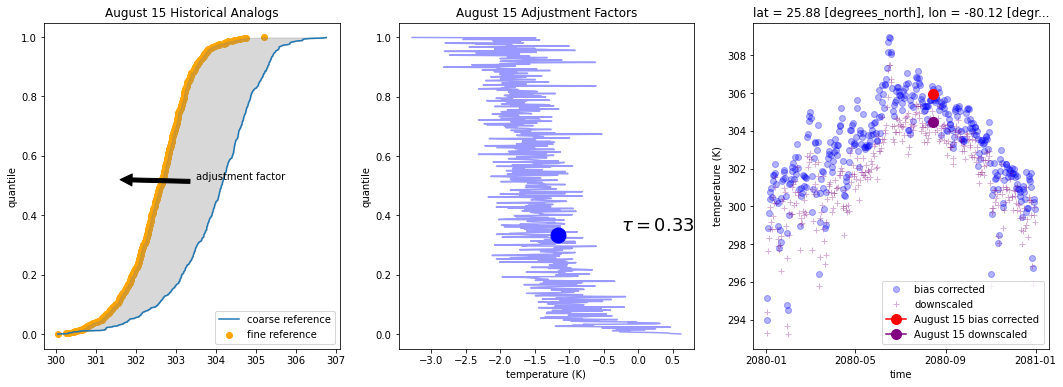

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(np.sort(tasmax_coarse.values), 
             np.linspace(0, 1, len(tasmax_coarse), endpoint=False), 
             label="coarse reference")

coarse_indices = np.argsort(tasmax_coarse.values)

axes[0].scatter(np.sort(tasmax_fine[coarse_indices].values), 
             np.linspace(0, 1, len(tasmax_fine), endpoint=False), marker='o', color='orange', 
             label="fine reference")

axes[0].fill_betweenx(np.linspace(0, 1, len(tasmax_fine), endpoint=False), 
                      np.sort(tasmax_fine[coarse_indices].values),
                      np.sort(tasmax_coarse.values),
                     alpha=0.3,
                     color='grey')

axes[0].annotate('adjustment factor', xy=(301.5, 0.52), xytext=(303.5, 0.52),
            arrowprops=dict(facecolor='black', shrink=0.05))

afs = np.sort(tasmax_coarse.values) - tasmax_fine[coarse_indices].values
'''axes[1].scatter(np.sort(afs), np.linspace(0, 1, len(tasmax_fine), endpoint=False), marker='+', 
                color='blue',
             label='adjustment factors')'''
# axes[1].plot(afs, np.linspace(0, 1, len(tasmax_fine), endpoint=False), alpha = 0.4, color='blue')
qplad_model.sel(lat=lat, lon=lon, method="nearest").sel(dayofyear=227)['af'].plot(y='quantiles', ax=axes[1], color='blue', alpha=0.4)
qplad_afs = qplad_model.sel(lat=lat, lon=lon, method="nearest").sel(dayofyear=227)['af']
'''axes[1].axhline(y=q, 
               linestyle='dashed', c="black",
               linewidth=3,
                zorder=0, alpha=0.3)'''

q_ind = np.argmin(np.abs(np.linspace(0, 1, len(tasmax_fine), endpoint=False) - q))

axes[1].plot(qplad_afs[q_ind], q, 'bo', markersize=15, label='adjustment factor') 

axes[1].text(-0.25, 0.35, r'$\tau={0:0.2f}$'.format(q), fontsize=18)

tasmax_sim_full.plot.line(marker='o', linewidth=0., ax=axes[2], color = 'blue', label='bias corrected', alpha=0.3)
tasmax_downscaled_full.plot.line(marker='+', linewidth=0., ax=axes[2], color = 'purple', label='downscaled', alpha=0.3)

# axes[0].plot(temp_sim, q, 'ro', markersize=15, label='June 15 2080') 

tasmax_sim.sel(time=slice(test_date, test_date)).plot.line(marker='o', c='r',
                                                                 markersize=10, 
                                                                 ax=axes[2], 
                                                       label='August 15 bias corrected')

tasmax_downscaled.sel(time=slice(test_date, test_date)).plot.line(marker='o', c='purple',
                                                                 markersize=10, 
                                                                 ax=axes[2], 
                                                       label='August 15 downscaled')

axes[2].legend(loc='lower right')      
axes[0].set_title('August 15 Historical Analogs')
axes[1].set_title('August 15 Adjustment Factors')
axes[0].set_ylabel('quantile')
axes[1].set_ylabel('quantile')
axes[1].set_xlabel('temperature (K)')
axes[2].set_ylabel('temperature (K)')
axes[0].legend(loc='lower right')

### revamp QPLAD diagram ### 

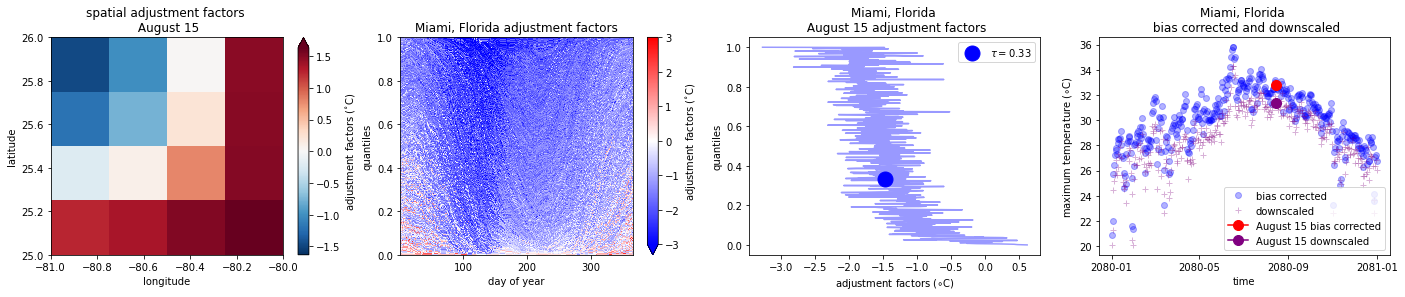

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(24, 4))
af_label = {'label': 'adjustment factors ($^{\circ}$C)'}

(tasmax_coarse_coarse.sel(time=slice(test_date, test_date))['tasmax'].values - ds_gridcell['tasmax']).plot(ax=axes[0], 
                                                                                                          robust=True, cbar_kwargs=af_label)
axes[0].plot(lon, lat)
axes[0].set_title('spatial adjustment factors \n August 15')


qplad_model.sel(lat=lat, lon=lon, method="nearest")['af'].plot(y='quantiles', vmin=-3, vmax=3, cmap='bwr', 
                                                              cbar_kwargs=af_label, ax=axes[1], 
                                                              )
axes[1].set_title('Miami, Florida adjustment factors')

q_ind = np.argmin(np.abs(np.linspace(0, 1, len(tasmax_fine), endpoint=False) - q))
qplad_model.sel(lat=lat, lon=lon, method="nearest").sel(dayofyear=227)['af'].plot(y='quantiles', ax=axes[2], color='blue', alpha=0.4)

af_exact = tasmax_sim.sel(time=slice(test_date, test_date)).values - tasmax_downscaled.sel(time=slice(test_date, test_date)).values
axes[2].plot(-1*af_exact, q, 'bo', markersize=15, label=r'$\tau={0:0.2f}$'.format(q)) 

# axes[2].text(-0.25, 0.35, r'$\tau={0:0.2f}$'.format(q), fontsize=18)

(tasmax_sim_full - 273.15).plot.line(marker='o', linewidth=0., ax=axes[3], color = 'blue', label='bias corrected', alpha=0.3)
(tasmax_downscaled_full - 273.15).plot.line(marker='+', linewidth=0., ax=axes[3], color = 'purple', label='downscaled', alpha=0.3)

(tasmax_sim.sel(time=slice(test_date, test_date)) - 273.15).plot.line(marker='o', c='r',
                                                                 markersize=10, 
                                                                 ax=axes[3], 
                                                       label='August 15 bias corrected')

(tasmax_downscaled.sel(time=slice(test_date, test_date)) - 273.15).plot.line(marker='o', c='purple',
                                                                 markersize=10, 
                                                                 ax=axes[3], 
                                                       label='August 15 downscaled')


axes[2].set_title('Miami, Florida \n August 15 adjustment factors')
axes[3].set_title('Miami, Florida \n bias corrected and downscaled')
axes[0].set_xlabel('longitude')
axes[0].set_ylabel('latitude')
axes[2].set_xlabel('adjustment factors (${\circ}$C)')
axes[1].set_xlabel('day of year')
axes[2].legend(loc='upper right')
axes[3].legend(loc='lower right')      
axes[3].set_ylabel('maximum temperature (${\circ}$C)')

plt.savefig(os.path.join(plot_dir, 'qplad_diagram.png'), 
            bbox_inches='tight', dpi=200)

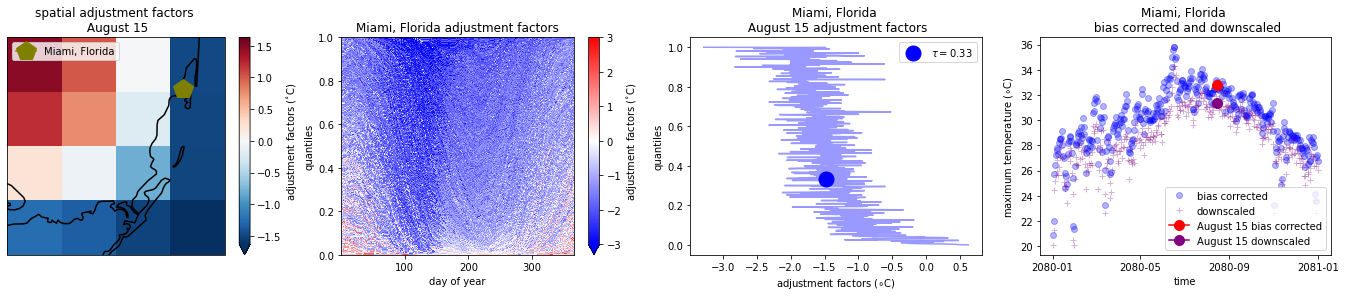

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(24, 4))
af_label = {'label': 'adjustment factors ($^{\circ}$C)'}

axes[0].remove()
ax_geo = fig.add_subplot(1, 4, 1, projection=ccrs.PlateCarree())

(ds_gridcell['tasmax'] - tasmax_coarse_coarse.sel(time=slice(test_date, test_date))['tasmax']).plot(ax=ax_geo, 
                                                                                                          robust=True, cbar_kwargs=af_label)
ax_geo.coastlines('10m', linewidth=1.5, color='black') # or however you want to style
# ax_geo.plot(lon, lat)
ax_geo.set_title('spatial adjustment factors \n August 15')
ax_geo.set_xlabel('lon')
ax_geo.set_ylabel('lat')
ax_geo.plot(lon, lat, marker='p', color='olive', markersize=20, label='Miami, Florida')
ax_geo.legend(loc='upper left')




qplad_model.sel(lat=lat, lon=lon, method="nearest")['af'].plot(y='quantiles', vmin=-3, vmax=3, cmap='bwr', 
                                                              cbar_kwargs=af_label, ax=axes[1], 
                                                              )
axes[1].set_title('Miami, Florida adjustment factors')

q_ind = np.argmin(np.abs(np.linspace(0, 1, len(tasmax_fine), endpoint=False) - q))
qplad_model.sel(lat=lat, lon=lon, method="nearest").sel(dayofyear=227)['af'].plot(y='quantiles', ax=axes[2], color='blue', alpha=0.4)

af_exact = tasmax_sim.sel(time=slice(test_date, test_date)).values - tasmax_downscaled.sel(time=slice(test_date, test_date)).values
axes[2].plot(-1*af_exact, q, 'bo', markersize=15, label=r'$\tau={0:0.2f}$'.format(q)) 

(tasmax_sim_full - 273.15).plot.line(marker='o', linewidth=0., ax=axes[3], color = 'blue', label='bias corrected', alpha=0.3)
(tasmax_downscaled_full - 273.15).plot.line(marker='+', linewidth=0., ax=axes[3], color = 'purple', label='downscaled', alpha=0.3)

(tasmax_sim.sel(time=slice(test_date, test_date)) - 273.15).plot.line(marker='o', c='r',
                                                                 markersize=10, 
                                                                 ax=axes[3], 
                                                       label='August 15 bias corrected')

(tasmax_downscaled.sel(time=slice(test_date, test_date)) - 273.15).plot.line(marker='o', c='purple',
                                                                 markersize=10, 
                                                                 ax=axes[3], 
                                                       label='August 15 downscaled')

axes[2].set_title('Miami, Florida \n August 15 adjustment factors')
axes[3].set_title('Miami, Florida \n bias corrected and downscaled')
axes[0].set_xlabel('longitude')
axes[0].set_ylabel('latitude')
axes[2].set_xlabel('adjustment factors (${\circ}$C)')
axes[1].set_xlabel('day of year')
axes[2].legend(loc='upper right')
axes[3].legend(loc='lower right')      
axes[3].set_ylabel('maximum temperature (${\circ}$C)')

plt.savefig(os.path.join(plot_dir, 'qplad_diagram_coastlines.png'), 
            bbox_inches='tight', dpi=200)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))

tasmax_sim_full.plot.line(marker='o', linewidth=0., ax=axes, label='bias corrected')
axes.legend()